# 1. Model

In [1]:
# Using pandas to process data
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
%matplotlib inline

from data_util import parse_bj_aq_data, plot_station, plot_stations, generate_model_data
from seq2seq.seq2seq_data_util import generate_x_y_data

In [2]:
print("Dimensions of the dataset for X and Y training examples : ")
print("X : (past_seq_length, batch_size, input_dim)")
print("y : (future_sequence_length, batch_size, output_dim)")

Dimensions of the dataset for X and Y training examples : 
X : (past_seq_length, batch_size, input_dim)
y : (future_sequence_length, batch_size, output_dim)


In [3]:
try:
    tf.nn.seq2seq = tf.contrib.legacy_seq2seq
    tf.nn.rnn_cell = tf.contrib.rnn
    tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell
    print("TensorFlow's version : 1.0 (or more)")
except: 
    print("TensorFlow's version : 0.12")

TensorFlow's version : 1.0 (or more)


In [4]:
# Internal neural network parameters
past_seq_length = 120
future_sequence_length = 4
batch_size = 32  # Low value used for live demo purposes - 100 and 1000 would be possible too, crank that up!

output_dim = input_dim = 1  # Output dimension (e.g.: multiple signals at once, tied in time)
hidden_dim = 100  # Count of hidden neurons in the recurrent units. 
layers_stacked_count = 2  # Number of stacked recurrent cells, on the neural depth axis. 

# Optmizer: 
learning_rate = 0.0007  # Small lr helps not to diverge during training. 
nb_iters = 1500  # How many times we perform a training step (therefore how many times we show a batch). 
lr_decay = 0.92  # default: 0.9 . Simulated annealing.
momentum = 0.5  # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting

In [5]:
tf.reset_default_graph()
# sess.close()
sess = tf.InteractiveSession()

with tf.variable_scope('Seq2seq'):

    # Encoder: inputs
    enc_inp = [
        tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
           for t in range(past_seq_length)
    ]

    # Decoder: expected outputs
    expected_sparse_output = [
        tf.placeholder(tf.float32, shape=(None, output_dim), name="expected_sparse_output_".format(t))
          for t in range(future_sequence_length)
    ]
    
    # Give a "GO" token to the decoder. 
    # Note: we might want to fill the encoder with zeros or its own feedback rather than with "+ enc_inp[:-1]"
    dec_inp = [ tf.zeros_like(enc_inp[0], dtype=np.float32, name="GO") ] + enc_inp[:-1]

    # Create a `layers_stacked_count` of stacked RNNs (GRU cells here). 
    cells = []
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
            # cells.append(tf.nn.rnn_cell.BasicLSTMCell(...))
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    
    # Here, the encoder and the decoder uses the same cell, HOWEVER,
    # the weights aren't shared among the encoder and decoder, we have two
    # sets of weights created under the hood according to that function's def. 
    dec_outputs, dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(
        enc_inp, 
        dec_inp, 
        cell
    )
    
    # For reshaping the output dimensions of the seq2seq RNN: 
    w_out = tf.Variable(tf.random_normal([hidden_dim, output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))
    
    # Final outputs: with linear rescaling for enabling possibly large and unrestricted output values.
    output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor")
    
    reshaped_outputs = [output_scale_factor*(tf.matmul(i, w_out) + b_out) for i in dec_outputs]

In [6]:
# Training loss and optimizer

with tf.variable_scope('Loss'):
    # L2 loss
    output_loss = 0
    for _y, _Y in zip(reshaped_outputs, expected_sparse_output):
        output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))
        
    # L2 regularization (to avoid overfitting and to have a  better generalization capacity)
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))
            
    loss = output_loss + lambda_l2_reg * reg_loss

with tf.variable_scope('Optimizer'):
    optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
    train_op = optimizer.minimize(loss)

In [7]:
def train_batch(ts, batch_size):
    """
    Training step that optimizes the weights 
    provided some batch_size X and Y examples from the dataset. 
    Generate new batch of training data for each new batch.
    """
    X, Y = generate_x_y_data(ts, past_seq_length, future_sequence_length, batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))})
    _, loss_t = sess.run([train_op, loss], feed_dict)
    return loss_t

In [8]:
def test_batch(ts, batch_size):
    """
    Test step, does NOT optimizes. Weights are frozen by not
    doing sess.run on the train_op. 
    """
    X, Y = generate_x_y_data(ts, past_seq_length, future_sequence_length, batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))})
    loss_t = sess.run([loss], feed_dict)
    return loss_t[0]

# 2. Model performance on toy data

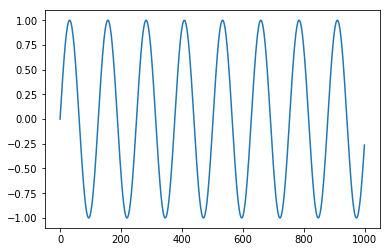

In [9]:
# 该数据用来验证模型的有效性
import pandas as pd

t = np.linspace(0,50,1000)
ts = np.sin(t)
ts = pd.Series(ts)

plt.plot(ts.values);

In [10]:
# Training
train_losses = []
test_losses = []

sess.run(tf.global_variables_initializer())
for t in range(nb_iters+1):
    train_loss = train_batch(ts, batch_size)
    train_losses.append(train_loss)
    
    if t % 10 == 0: 
        # Tester
        test_loss = test_batch(ts, batch_size)
        test_losses.append(test_loss)
        print("Step {}/{}, train loss: {}, \tTEST loss: {}".format(t, nb_iters, train_loss, test_loss))

print("Fin. train loss: {}, \tTEST loss: {}".format(train_loss, test_loss))

Step 0/1500, train loss: 36.15339279174805, 	TEST loss: 125.42847442626953
Step 10/1500, train loss: 3.1334898471832275, 	TEST loss: 3.157756805419922
Step 20/1500, train loss: 3.110814094543457, 	TEST loss: 3.1048476696014404
Step 30/1500, train loss: 3.1065945625305176, 	TEST loss: 3.1068480014801025
Step 40/1500, train loss: 15.25310230255127, 	TEST loss: 16.544254302978516
Step 50/1500, train loss: 3.125783681869507, 	TEST loss: 3.11944842338562
Step 60/1500, train loss: 3.095085859298706, 	TEST loss: 3.1030592918395996
Step 70/1500, train loss: 5.705568313598633, 	TEST loss: 3.7522659301757812
Step 80/1500, train loss: 3.0886905193328857, 	TEST loss: 3.0830705165863037
Step 90/1500, train loss: 3.4079837799072266, 	TEST loss: 4.337352275848389
Step 100/1500, train loss: 3.361966848373413, 	TEST loss: 3.236499547958374
Step 110/1500, train loss: 3.058084487915039, 	TEST loss: 3.0649778842926025
Step 120/1500, train loss: 3.279892683029175, 	TEST loss: 3.224532127380371
Step 130/150

Step 1060/1500, train loss: 0.3838086426258087, 	TEST loss: 0.3775617778301239
Step 1070/1500, train loss: 0.39762914180755615, 	TEST loss: 0.46080130338668823
Step 1080/1500, train loss: 0.35854214429855347, 	TEST loss: 0.3586496114730835
Step 1090/1500, train loss: 0.5064189434051514, 	TEST loss: 0.3711366653442383
Step 1100/1500, train loss: 0.35113972425460815, 	TEST loss: 0.35075807571411133
Step 1110/1500, train loss: 0.3815980553627014, 	TEST loss: 0.3551415205001831
Step 1120/1500, train loss: 0.5104324817657471, 	TEST loss: 0.3629169762134552
Step 1130/1500, train loss: 0.3396477699279785, 	TEST loss: 0.3391106128692627
Step 1140/1500, train loss: 0.35708898305892944, 	TEST loss: 0.4259219765663147
Step 1150/1500, train loss: 0.34863120317459106, 	TEST loss: 0.35314124822616577
Step 1160/1500, train loss: 0.3297842741012573, 	TEST loss: 0.3301341235637665
Step 1170/1500, train loss: 0.3581729531288147, 	TEST loss: 0.33725735545158386
Step 1180/1500, train loss: 0.3326390981674

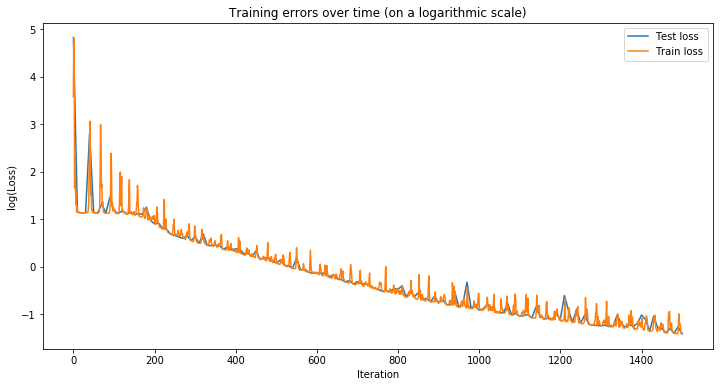

In [11]:
# Plot loss over time:
plt.figure(figsize=(12, 6))
plt.plot(
    np.array(range(0, len(test_losses)))/float(len(test_losses)-1)*(len(train_losses)-1), 
    np.log(test_losses), 
    label="Test loss"
)
plt.plot(
    np.log(train_losses), 
    label="Train loss"
)
plt.title("Training errors over time (on a logarithmic scale)")
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.legend(loc='best')
plt.show()


Let's visualize 5 predictions with our signals:


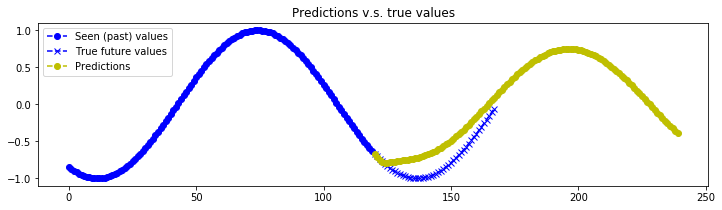

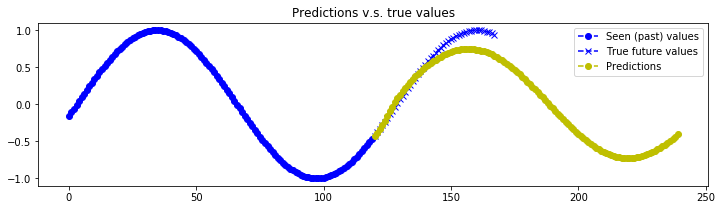

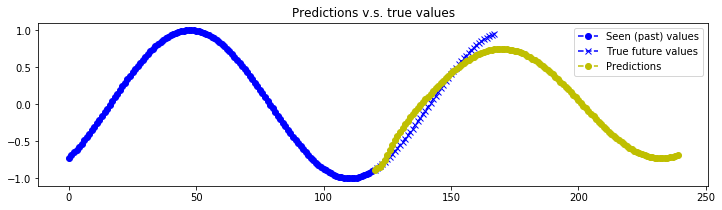

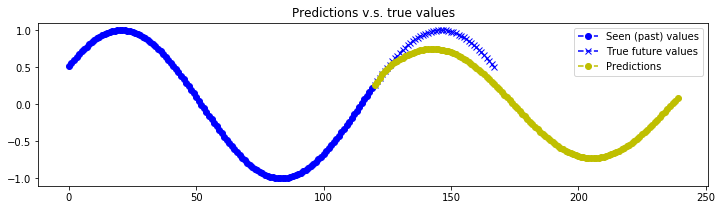

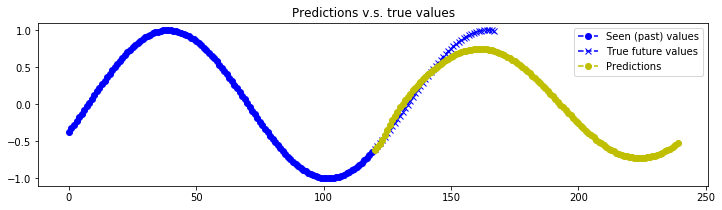

Reminder: the signal can contain many dimensions at once.
In that case, signals have the same color.
In reality, we could imagine multiple stock market symbols evolving,
tied in time together and seen at once by the neural network.


In [12]:
# Test
nb_predictions = 5
print("Let's visualize {} predictions with our signals:".format(nb_predictions))

X, Y = generate_x_y_data(ts, 120, 48,batch_size=nb_predictions)
feed_dict = {enc_inp[t]: X[t] for t in range(past_seq_length)}
outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])

for j in range(nb_predictions): 
    plt.figure(figsize=(12, 3))
    
    for k in range(output_dim):
        past = X[:,j,k]
        expected = Y[:,j,k]
        pred = outputs[:,j,k]
        
        label1 = "Seen (past) values" if k==0 else "_nolegend_"
        label2 = "True future values" if k==0 else "_nolegend_"
        label3 = "Predictions" if k==0 else "_nolegend_"
        plt.plot(range(len(past)), past, "o--b", label=label1)
        plt.plot(range(len(past), len(expected)+len(past)), expected, "x--b", label=label2)
        plt.plot(range(len(past), len(pred)+len(past)), pred, "o--y", label=label3)
    
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()

print("Reminder: the signal can contain many dimensions at once.")
print("In that case, signals have the same color.")
print("In reality, we could imagine multiple stock market symbols evolving,")
print("tied in time together and seen at once by the neural network.")

# 3. Model performance on real data

In [13]:
bj_aq_data, stations, bj_aq_stations, bj_aq_stations_merged = parse_bj_aq_data()

NaN in PM2.5 is 23459, 6.508615 %
NaN in PM10 is 96175, 26.683406 %
NaN in NO2 is 21720, 6.026135 %
NaN in CO is 46144, 12.802486 %
NaN in O3 is 23732, 6.584358 %
NaN in SO2 is 21664, 6.010598 %
There are 35 air quality stations in Beijing

The stations in Beijing are:
 {'yongdingmennei_aq', 'yizhuang_aq', 'dingling_aq', 'dongsihuan_aq', 'huairou_aq', 'pinggu_aq', 'tongzhou_aq', 'nongzhanguan_aq', 'tiantan_aq', 'pingchang_aq', 'wanshouxigong_aq', 'badaling_aq', 'zhiwuyuan_aq', 'miyunshuiku_aq', 'wanliu_aq', 'yungang_aq', 'xizhimenbei_aq', 'fengtaihuayuan_aq', 'liulihe_aq', 'shunyi_aq', 'yufa_aq', 'aotizhongxin_aq', 'yongledian_aq', 'yanqin_aq', 'daxing_aq', 'fangshan_aq', 'mentougou_aq', 'gucheng_aq', 'beibuxinqu_aq', 'guanyuan_aq', 'dongsi_aq', 'miyun_aq', 'qianmen_aq', 'donggaocun_aq', 'nansanhuan_aq'}


/notebooks/KDD_Cup_2018/data_util.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  bj_aq_station.drop("utc_time", axis=1, inplace=True)
/notebooks/KDD_Cup_2018/data_util.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  bj_aq_station.drop("stationId", axis=1, inplace=True)


In [14]:
ts = bj_aq_stations_merged["pinggu_aq_PM2.5"]

In [15]:
# Training
train_losses = []
test_losses = []

sess.run(tf.global_variables_initializer())
for t in range(nb_iters+1):
    train_loss = train_batch(ts, batch_size)
    train_losses.append(train_loss)
    
    if t % 10 == 0: 
        # Tester
        test_loss = test_batch(ts, batch_size)
        test_losses.append(test_loss)
        print("Step {}/{}, train loss: {}, \tTEST loss: {}".format(t, nb_iters, train_loss, test_loss))

print("Fin. train loss: {}, \tTEST loss: {}".format(train_loss, test_loss))

Step 0/1500, train loss: 348180.5625, 	TEST loss: 167037.78125
Step 10/1500, train loss: 256469.59375, 	TEST loss: 143214.234375
Step 20/1500, train loss: 226582.65625, 	TEST loss: 62561.44140625
Step 30/1500, train loss: 132582.3125, 	TEST loss: 81342.0234375
Step 40/1500, train loss: 103904.46875, 	TEST loss: 108589.21875
Step 50/1500, train loss: 188867.59375, 	TEST loss: 68607.953125
Step 60/1500, train loss: 30775.203125, 	TEST loss: 128920.9296875
Step 70/1500, train loss: 42669.4765625, 	TEST loss: 20262.927734375
Step 80/1500, train loss: 33817.26953125, 	TEST loss: 93628.2890625
Step 90/1500, train loss: 564095.0, 	TEST loss: 78891.234375
Step 100/1500, train loss: 109588.1171875, 	TEST loss: 49848.734375
Step 110/1500, train loss: 208483.34375, 	TEST loss: 128700.828125
Step 120/1500, train loss: 132504.421875, 	TEST loss: 52625.890625
Step 130/1500, train loss: 20847.537109375, 	TEST loss: 90360.7421875
Step 140/1500, train loss: 35169.07421875, 	TEST loss: 41774.16015625
St

Step 1200/1500, train loss: 62938.78125, 	TEST loss: 20984.564453125
Step 1210/1500, train loss: 15188.9453125, 	TEST loss: 35364.4921875
Step 1220/1500, train loss: 19082.123046875, 	TEST loss: 75801.828125
Step 1230/1500, train loss: 56509.03125, 	TEST loss: 39280.90234375
Step 1240/1500, train loss: 38813.84765625, 	TEST loss: 24571.03125
Step 1250/1500, train loss: 31556.408203125, 	TEST loss: 25917.400390625
Step 1260/1500, train loss: 61689.0078125, 	TEST loss: 22034.763671875
Step 1270/1500, train loss: 48974.38671875, 	TEST loss: 22563.11328125
Step 1280/1500, train loss: 16903.099609375, 	TEST loss: 77731.140625
Step 1290/1500, train loss: 17146.974609375, 	TEST loss: 95038.3515625
Step 1300/1500, train loss: 40882.55859375, 	TEST loss: 168288.625
Step 1310/1500, train loss: 50360.5390625, 	TEST loss: 19331.123046875
Step 1320/1500, train loss: 19823.841796875, 	TEST loss: 29551.86328125
Step 1330/1500, train loss: 27779.205078125, 	TEST loss: 27875.73828125
Step 1340/1500, tr

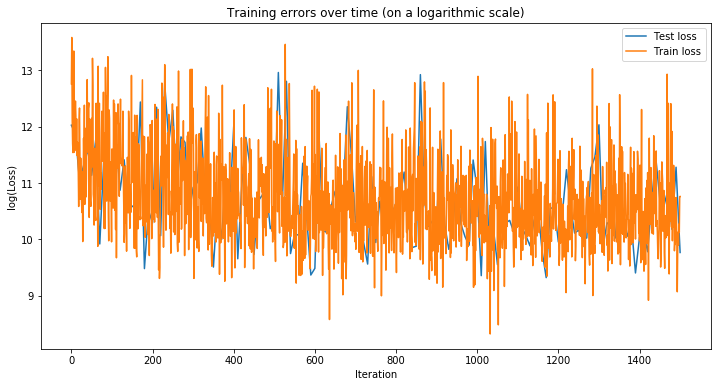

In [16]:
# Plot loss over time:
plt.figure(figsize=(12, 6))
plt.plot(
    np.array(range(0, len(test_losses)))/float(len(test_losses)-1)*(len(train_losses)-1), 
    np.log(test_losses), 
    label="Test loss"
)
plt.plot(
    np.log(train_losses), 
    label="Train loss"
)
plt.title("Training errors over time (on a logarithmic scale)")
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.legend(loc='best')
plt.show()

Let's visualize 5 predictions with our signals:


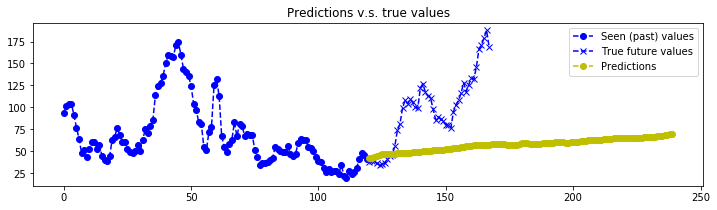

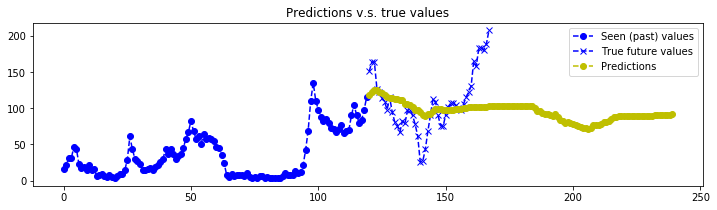

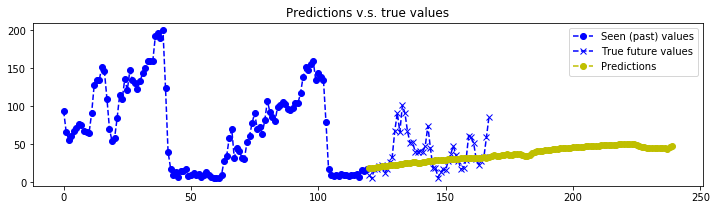

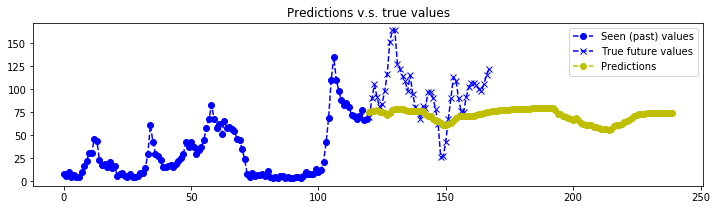

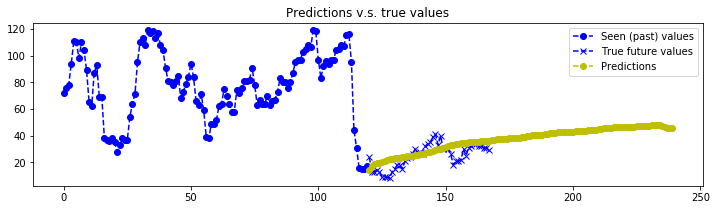

Reminder: the signal can contain many dimensions at once.
In that case, signals have the same color.
In reality, we could imagine multiple stock market symbols evolving,
tied in time together and seen at once by the neural network.


In [17]:
# Test
nb_predictions = 5
print("Let's visualize {} predictions with our signals:".format(nb_predictions))

X, Y = generate_x_y_data(ts, 120, 48,batch_size=nb_predictions)
feed_dict = {enc_inp[t]: X[t] for t in range(past_seq_length)}
outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])

for j in range(nb_predictions): 
    plt.figure(figsize=(12, 3))
    
    for k in range(output_dim):
        past = X[:,j,k]
        expected = Y[:,j,k]
        pred = outputs[:,j,k]
        
        label1 = "Seen (past) values" if k==0 else "_nolegend_"
        label2 = "True future values" if k==0 else "_nolegend_"
        label3 = "Predictions" if k==0 else "_nolegend_"
        plt.plot(range(len(past)), past, "o--b", label=label1)
        plt.plot(range(len(past), len(expected)+len(past)), expected, "x--b", label=label2)
        plt.plot(range(len(past), len(pred)+len(past)), pred, "o--y", label=label3)
    
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()

print("Reminder: the signal can contain many dimensions at once.")
print("In that case, signals have the same color.")
print("In reality, we could imagine multiple stock market symbols evolving,")
print("tied in time together and seen at once by the neural network.")

In [27]:
writer = tf.summary.FileWriter('./tmp/1')
writer.add_graph(sess.graph)

In [28]:
!tensorboard --logdir /notebooks/KDD_Cup_2018/tmp/1

Starting TensorBoard b'55' at http://5e191e6580c6:6006
(Press CTRL+C to quit)
^C


In [ ]:
# 参考下边的模型修改 自己的模型

def decoding_layer(target_letter_to_int, decoding_embedding_size, num_layers, rnn_size,
                   target_sequence_length, max_target_sequence_length, encoder_state, decoder_input):
    '''
    构造Decoder层
    
    参数：
    - target_letter_to_int: target数据的映射表
    - decoding_embedding_size: embed向量大小
    - num_layers: 堆叠的RNN单元数量
    - rnn_size: RNN单元的隐层结点数量
    - target_sequence_length: target数据序列长度
    - max_target_sequence_length: target数据序列最大长度
    - encoder_state: encoder端编码的状态向量
    - decoder_input: decoder端输入
    '''
    # 1. Embedding
    target_vocab_size = len(target_letter_to_int)
    decoder_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, decoding_embedding_size]))
    decoder_embed_input = tf.nn.embedding_lookup(decoder_embeddings, decoder_input)

    # 2. 构造Decoder中的RNN单元
    def get_decoder_cell(rnn_size):
        decoder_cell = tf.contrib.rnn.LSTMCell(rnn_size,
                                           initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
        return decoder_cell
    cell = tf.contrib.rnn.MultiRNNCell([get_decoder_cell(rnn_size) for _ in range(num_layers)])
     
    # 3. Output全连接层
    output_layer = Dense(target_vocab_size,
                         kernel_initializer = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))


    # 4. Training decoder
    with tf.variable_scope("decode"):
        # 得到help对象
        training_helper = tf.contrib.seq2seq.TrainingHelper(inputs=decoder_embed_input,
                                                            sequence_length=target_sequence_length,
                                                            time_major=False)
        # 构造decoder
        training_decoder = tf.contrib.seq2seq.BasicDecoder(cell,
                                                           training_helper,
                                                           encoder_state,
                                                           output_layer) 
        training_decoder_output, _ = tf.contrib.seq2seq.dynamic_decode(training_decoder,
                                                                       impute_finished=True,
                                                                       maximum_iterations=max_target_sequence_length)
    # 5. Predicting decoder
    # 与training共享参数
    with tf.variable_scope("decode", reuse=True):
        # 创建一个常量tensor并复制为batch_size的大小
        start_tokens = tf.tile(tf.constant([target_letter_to_int['<GO>']], dtype=tf.int32), [batch_size], 
                               name='start_tokens')
        predicting_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(decoder_embeddings,
                                                                start_tokens,
                                                                target_letter_to_int['<EOS>'])
        predicting_decoder = tf.contrib.seq2seq.BasicDecoder(cell,
                                                        predicting_helper,
                                                        encoder_state,
                                                        output_layer)
        predicting_decoder_output, _ = tf.contrib.seq2seq.dynamic_decode(predicting_decoder,
                                                            impute_finished=True,
                                                            maximum_iterations=max_target_sequence_length)
    
    return training_decoder_output, predicting_decoder_output

# ChangeLog
- 20180114 v0 完成了 seq2seq 模型的最初版本
    - 遇到了如下问题
        1. 模型的定义中，dec_inp 的定义有疑问。感觉应该使用 expected_sparse_output 中的部分，而不是 enc_inp 中的部分
        2. 如何对 tf 进行 debug？如何查看计算图，如何更好的使用 tensorboard 进行 debug
    - TODO
        1. 对照上个 cell 中 decode 部分的思路，对现有模型进行修改

In [35]:
# Training
# model args neet to be specified.
# def train(ts, nb_iters):
#     train_losses = []
#     test_losses = []

#     sess.run(tf.global_variables_initializer())
#     for t in range(nb_iters+1):
#         train_loss = train_batch(ts, batch_size)
#         train_losses.append(train_loss)

#         if t % 10 == 0: 
#             # Tester
#             test_loss = test_batch(ts, batch_size)
#             test_losses.append(test_loss)
#             print("Step {}/{}, train loss: {}, \tTEST loss: {}".format(t, nb_iters, train_loss, test_loss))

#     print("Fin. train loss: {}, \tTEST loss: {}".format(train_loss, test_loss))
    
#     return train_losses, test_losses